In [1]:
!pip install openpyxl
!pip install transformers
!pip install pyvi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.9 MB/s 
     |████████████████████████████████| 7.6 MB 16.8 MB/s 
     |████████████████████████████████| 182 kB 64.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.5 MB 4.7 MB/s 
     |████████████████████████████████| 1.0 MB 68.4 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
  import os 
  os.chdir('drive/MyDrive/Colab Notebooks/Sentiment')
  #print(os.getcwd())


In [4]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import models

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

from sklearn.model_selection import KFold
from google.colab import files

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

In [5]:
train_df = pd.read_csv('train_processed.csv')

In [6]:
test_df = pd.read_csv('test_processed.csv')

In [7]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
EPOCHS = 6
N_SPLITS = 5

In [9]:
device

device(type='cuda', index=0)

In [10]:
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.Rating)):
    train_df.loc[val_, "kfold"] = fold

In [11]:
def fillComment(df):
    for index, row in df.iterrows():
        #print(df['Comment'].loc[index])
        if (df['Comment'].loc[index]) == '':
            df['Comment'].loc[index] = 'tích_cực'
            print(df['Comment'].loc[index])
    return df
train_df = fillComment(train_df)

In [12]:
import re
def clean(x):
    x = x.lower()
    x = re.sub("[^\w\d]"," ",x)
    #x = " ".join([y for y in x.split() if y not in STOPWORDS])
    x = x.replace('_','')
    return x

In [13]:
train_df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'RevId', 'UserId', 'image_urls'], inplace=True)
train_df = train_df.dropna()
train_df.reset_index(drop=True)

test_df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'RevId', 'UserId', 'image_urls'], inplace=True)
test_df = test_df.dropna()
test_df.reset_index(drop=True)

,Comment
0,trà táo 35k cookie socola 38k nước đây bình_th...
1,hôm trung_tâm tổ_chức noel party đây mua vouch...
2,thịt gà quán đấy đi gọi liền 4 món chân gà cán...
3,hai đứa xong đau bụng ngày chân gà ok nước khô...
4,mình thử trưa nay điểm cộng đầu_tiên bát bún đ...
...,...
5096,bún riêu ngon mà nào đông trên foody chả được ...
5097,quán thoải_mái cưc menu đa_dạng ăn_uống giá hợ...
5098,quá thất_vọng chất sản_phẩm càng đi xuống hôm ...
5099,giao hàng nhanh miếng băm chả ngon không cháy ...


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9066 entries, 0 to 9069
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Comment  9066 non-null   object 
 1   Rating   9066 non-null   float64
 2   kfold    9066 non-null   float64
dtypes: float64(2), object(1)
memory usage: 283.3+ KB


In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5101 entries, 0 to 5102
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5101 non-null   object
dtypes: object(1)
memory usage: 79.7+ KB


In [16]:
train_df['Comment'].apply(lambda x :  clean(x))

0            xôi dẻo đồ đậm vị hộp xôi lót lá trông thích
1       gọi giao hàng 1 xuất cari gà bánh naan 3 miếng...
2       thờitiết lạnh này nhà rủ đến legarden hếtý nhà...
3       em đọc review mọi người bảo trà sữa nướng free...
4       đồ rất ngon hàng rất đẹp tất đều ok đến chờ 2 ...
                              ...                        
9065    thực mà thấy người đánhgiá quá đi thử xem phải...
9066    tích  cực tích  cực tích  cực lẩu thái tômyum ...
9067    ngay lúc đầutiên vào hàng được nhânviên đóntiế...
9068        đặt thử thấy ngón cá còn ủn hộ quán nhìu nhìu
9069    nay bóngđá việtnam lười nấu cơm nghe bạn giớit...
Name: Comment, Length: 9066, dtype: object

In [17]:
test_df['Comment'].apply(lambda x :  clean(x))

0       trà táo 35k cookie socola 38k nước đây bìnhthư...
1       hôm trungtâm tổchức noel party đây mua voucher...
2       thịt gà quán đấy đi gọi liền 4 món chân gà cán...
3       hai đứa xong đau bụng ngày chân gà ok nước khô...
4       mình thử trưa nay điểm cộng đầutiên bát bún đặ...
                              ...                        
5098    bún riêu ngon mà nào đông trên foody chả được ...
5099    quán thoảimái cưc menu đadạng ănuống giá hợplí...
5100    quá thấtvọng chất sảnphẩm càng đi xuống hôm đầ...
5101    giao hàng nhanh miếng băm chả ngon không cháy ...
5102    nhìn trông quán bé vào thấy không bí lắm kha n...
Name: Comment, Length: 5101, dtype: object

In [18]:
test_df

,Comment
0,trà táo 35k cookie socola 38k nước đây bình_th...
1,hôm trung_tâm tổ_chức noel party đây mua vouch...
2,thịt gà quán đấy đi gọi liền 4 món chân gà cán...
3,hai đứa xong đau bụng ngày chân gà ok nước khô...
4,mình thử trưa nay điểm cộng đầu_tiên bát bún đ...
...,...
5098,bún riêu ngon mà nào đông trên foody chả được ...
5099,quán thoải_mái cưc menu đa_dạng ăn_uống giá hợ...
5100,quá thất_vọng chất sản_phẩm càng đi xuống hôm ...
5101,giao hàng nhanh miếng băm chả ngon không cháy ...


In [19]:
test_df

,Comment
0,trà táo 35k cookie socola 38k nước đây bình_th...
1,hôm trung_tâm tổ_chức noel party đây mua vouch...
2,thịt gà quán đấy đi gọi liền 4 món chân gà cán...
3,hai đứa xong đau bụng ngày chân gà ok nước khô...
4,mình thử trưa nay điểm cộng đầu_tiên bát bún đ...
...,...
5098,bún riêu ngon mà nào đông trên foody chả được ...
5099,quán thoải_mái cưc menu đa_dạng ăn_uống giá hợ...
5100,quá thất_vọng chất sản_phẩm càng đi xuống hôm ...
5101,giao hàng nhanh miếng băm chả ngon không cháy ...


In [20]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/895k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

In [21]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return 
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['Comment']
        text = ' '.join(simple_preprocess(text))
        label = row['Rating']

        return text, label

Text(0.5, 6.79999999999999, 'Token Count')

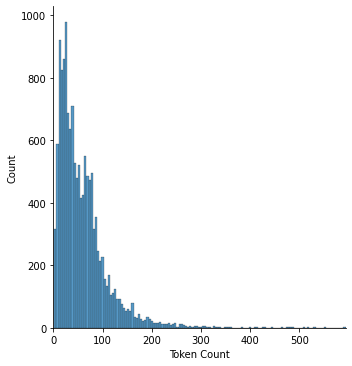

In [22]:
all_data = train_df.Comment.tolist() + test_df.Comment.tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

In [23]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        
        self.bert_clf = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.bert.config.hidden_size, 256)          
            #nn.Softmax()
        )
        self.LSTM = nn.LSTM(256,512,bidirectional=True)
        self.final_clf = nn.Sequential(
            #nn.Flatten(),
            nn.Linear(256, 64),
            nn.Dropout(0.2),
            nn.Linear(64, 2),
            nn.Softmax()
        )
    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )
        x = self.bert_clf(output)
        #x = x.view(128,3,1,32)
        lstm_out, hidden = self.LSTM(x)
        #lstm_out, hidden = self.LSTM2(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, 256)
       
        #x = self.vgg_clf(x)
        x = self.final_clf(x)
        return x
    # def __init__(self, n_classes):
    #     super(SentimentClassifier, self).__init__()
    #     self.bert = AutoModel.from_pretrained("vinai/phobert-base")
    #     self.drop = nn.Dropout(p=0.3)
    #     self.fc = nn.Linear(self.bert.config.hidden_size, 2)
    #     nn.init.normal_(self.fc.weight, std=0.02)
    #     nn.init.normal_(self.fc.bias, 0)

    # def forward(self, input_ids, attention_mask):
    #     last_hidden_state, output = self.bert(
    #         input_ids=input_ids,
    #         attention_mask=attention_mask,
    #         return_dict=False # Dropout will errors if without this
    #     )

    #     x = self.drop(output)
    #     x = self.fc(x)
    #     return x

    

In [24]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())
    
    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)

In [25]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = SentimentDataset(df_train, tokenizer, max_len=120)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=120)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)
    
    return train_loader, valid_loader

In [ ]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = SentimentClassifier(n_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = Adam(model.parameters(), lr=2e-5)
    
    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer, 
                num_warmup_steps=0, 
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'phobert_fold{fold+1}.pth')
            best_acc = val_acc

-----------Fold: 1 ------------------


Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

Epoch 1/6
------------------------------
Train Accuracy: 0.8597628240485384 Loss: 0.4571896756666872
Valid Accuracy: 0.9145534729878722 Loss: 0.3988364255219175
Epoch 2/6
------------------------------
Train Accuracy: 0.9131274131274132 Loss: 0.399629819038681
Valid Accuracy: 0.9178610804851158 Loss: 0.3950537011811608
Epoch 3/6
------------------------------
Train Accuracy: 0.9186431329288473 Loss: 0.3944594692028567
Valid Accuracy: 0.9117971334068358 Loss: 0.40083384095576774
Epoch 4/6
------------------------------
Train Accuracy: 0.9196083838940983 Loss: 0.39328677400880974
Valid Accuracy: 0.9206174200661522 Loss: 0.3933301238637221
Epoch 5/6
------------------------------
Train Accuracy: 0.9269167126309984 Loss: 0.38641496908559675
Valid Accuracy: 0.9106945975744212 Loss: 0.40163221667733107
Epoch 6/6
------------------------------


In [ ]:
def infer(text, tokenizer, max_len=120):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)
    #print(y_pred)

    return y_pred

label = []

for index, text in test_df.iterrows():
    text = test_df['Comment'].loc[index]
    #print(text)
    label.append(infer(text,tokenizer))


In [ ]:
label

In [ ]:
test_print = pd.read_csv('test_processed.csv')

In [ ]:
for i in range(len(label)):
    label[i] = label[i].item()


In [ ]:
label[0]

1

In [ ]:
test_print['Rating'] = label

In [ ]:
test_print = test_print.drop(columns=['Unnamed: 0', 'Unnamed: 0.1','UserId','Comment','image_urls'])

In [ ]:
test_print.to_csv('prediction.csv',index=False)